In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from torch.distributions import Categorical
from tqdm import tqdm

sys.path.append('../src')
from nets import MLP
from sim import make_dataset
from util import map_labels, show_dataset

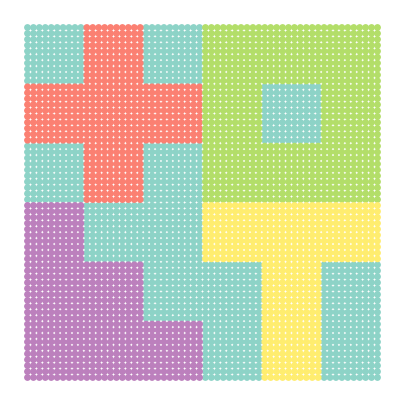

In [2]:
data, labels = make_dataset()
show_dataset(data, labels)

In [3]:
def relable(cs):
    cs, d, k = cs.copy(), {}, 0
    
    for i in range(len(cs)):
        j = cs[i]

        if j not in d:
            d[j] = k
            k += 1
        
        cs[i] = d[j]

    return cs

def generate(alpha=.7, N=None, N_min=5, N_max=100, no_ones=False,):
    keep = True

    while keep:
        if N is None or N == 0:
            N = np.random.randint(N_min, N_max)
        clusters = np.zeros(N + 2)
        clusters[0], clusters[1], clusters[2] = 0, 1, alpha
        index_new = 2

        for n in range(N - 1):
            p = clusters/clusters.sum()
            z = np.argmax(np.random.multinomial(1, p))

            if z < index_new:
                clusters[z] += 1
            else:
                clusters[index_new] = 1
                index_new += 1
                clusters[index_new] = alpha

        clusters[index_new] = 0
        clusters = clusters.astype(np.int32)

        if no_ones:
            clusters = clusters[clusters != 1]

        N = int(np.sum(clusters))
        keep = N == 0

    K = np.sum(clusters > 0)

    return clusters, N, K

class Data:
    def __init__(self, x_dim=2, lamb=10, sigma=1, alpha=.7, N_min=5, N_max=100):
        self.x_dim = x_dim
        self.lamb = lamb
        self.sigma = sigma
        self.alpha = alpha
        self.N_min = N_min
        self.N_max = N_max

    def generate(self, N=None, batch_size=64):
        clusters, N, n_clusters = generate(self.alpha, N, self.N_min, self.N_max)
        cumsum = np.cumsum(clusters)
        data = np.empty((batch_size, N, self.x_dim))
        cs = np.empty(N, dtype=np.int32)

        for i in range(n_clusters):
            mu = np.random.normal(0, self.lamb, size=(self.x_dim*batch_size, 1))
            samples = np.random.normal(mu, self.sigma, size=(self.x_dim*batch_size, clusters[i + 1]))
            samples = np.swapaxes(samples.reshape((batch_size, self.x_dim, clusters[i + 1])), 1, 2)
            data[:, cumsum[i]:cumsum[i + 1], :] = samples
            cs[cumsum[i]:cumsum[i + 1]] = i + 1

        arr = np.arange(N)
        np.random.shuffle(arr)
        cs = cs[arr]
        data = data[:, arr, :]
        cs = relable(cs)
        medians = np.expand_dims(np.median(data, axis=1), 1)
        data = data - medians

        return data, cs, clusters, n_clusters

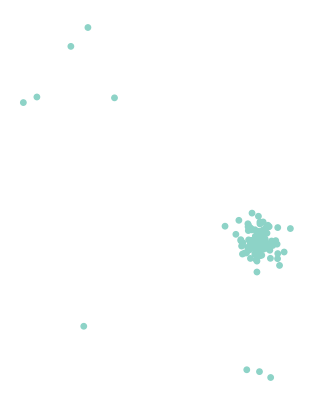

In [4]:
generator = Data()
data, cs, clusters, n_clusters = generator.generate(N=100)
show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[0]]), np.ones(data.shape[1]))

In [15]:
class Encoder(nn.Module):
    def __init__(self, H_dim=128, h_dim=256, x_dim=2, activation='prelu'):
        super().__init__()

        self.H_dim = H_dim
        self.h_dim = h_dim
        self.x_dim = x_dim

        self.h = MLP(x_dim, H_dim, H_dim, H_dim, H_dim, h_dim, activation=activation)

    def forward(self, x):
        return self.h(x)
    
class NCP(nn.Module):
    def __init__(self, H_dim=128, h_dim=256, x_dim=2, g_dim=512, activation='prelu'):
        super().__init__()

        self.H_dim = H_dim
        self.h_dim = h_dim
        self.x_dim = x_dim
        self.g_dim = g_dim

        self.h = Encoder(self.H_dim, self.h_dim, self.x_dim)
        self.q = Encoder(self.H_dim, self.h_dim, self.x_dim)
        self.g = MLP(h_dim, H_dim, H_dim, H_dim, H_dim, H_dim, g_dim, activation=activation)
        self.f = MLP(g_dim + h_dim, H_dim, H_dim, H_dim, H_dim, 1, activation=activation, out_bias=False)

        self.previous_n = 0
        self.previous_K = 1

    def forward(self, data, cs, n):
        self.previous_n = self.previous_n + 1
        K = len(set(cs[:n]))

        if n == 1:
            self.batch_size = data.shape[0]
            self.N = data.shape[1]
            data = torch.tensor(data).float()
            data = data.reshape((self.batch_size*self.N, self.x_dim))
            self.hs = self.h(data).view([self.batch_size, self.N, self.h_dim])
            self.Hs = torch.zeros([self.batch_size, 1, self.h_dim])
            self.Hs[:, 0, :] = self.hs[:, 0, :]
            self.qs = self.q(data).view([self.batch_size, self.N, self.h_dim])
            self.Q = self.qs[:, 2:,].sum(dim=1)
        else:
            if K == self.previous_K:
                self.Hs[:, cs[n - 1], :] += self.hs[:, n - 1, :]
            else:
                self.Hs = torch.cat((self.Hs, self.hs[:, n - 1, :].unsqueeze(1)), dim=1)

            if n == self.N - 1:
                self.Q = torch.zeros((self.batch_size, self.h_dim))
                self.previous_n = 0
            else:
                self.Q -= self.qs[:, n,]

        self.previous_K = K
        logprobs = torch.zeros((self.batch_size, K + 1))

        for k in range(K):
            Hs2 = self.Hs.clone()
            Hs2[:, k, :] += self.hs[:, n, :]
            Hs2 = Hs2.view((self.batch_size*K, self.h_dim))
            gs = self.g(Hs2).view([self.batch_size, K, self.g_dim])
            Gk = gs.sum(dim=1)
            uu = torch.cat((Gk, self.Q), dim=1)
            logprobs[:, k] = torch.squeeze(self.f(uu))

        Hs2 = torch.cat((self.Hs, self.hs[:, n, :].unsqueeze(1)), dim=1)
        Hs2 = Hs2.view((self.batch_size*(K + 1), self.h_dim))
        gs = self.g(Hs2).view((self.batch_size, K + 1, self.g_dim))
        Gk = gs.sum(dim=1)
        uu = torch.cat((Gk, self.Q), dim=1)
        logprobs[:, K] = torch.squeeze(self.f(uu))
        m, _ = torch.max(logprobs, 1, keepdim=True)
        logprobs = logprobs - m - torch.log(torch.exp(logprobs - m).sum(dim=1, keepdim=True))

        return logprobs

In [16]:
x_dim = 2
dpmm = NCP(x_dim=x_dim)
generator = Data(x_dim)
losses, accs, perm_vars = [], [], []
it = 0
learning_rate = 1e-4
weight_decay = .01
optimizer = torch.optim.Adam(dpmm.parameters(), lr=learning_rate, weight_decay=weight_decay)
perms = 6
batch_size = 64
max_it = 200
learning_rates = {1200: 5e-5, 2200: 1e-5}
itt = it

while True:
    it += 1

    if it == max_it:
        break

    dpmm.train()

    if it in learning_rates:
        optimizer = torch.optim.Adam(dpmm.parameters(), lr=learning_rate[it], weight_decay=weight_decay)
    
    data, cs, clusters, K = generator.generate(None, batch_size)
    N = data.shape[1]
    loss_values = np.zeros(perms)
    accuracies = np.zeros([N - 1, perms])

    while True:
        loss = 0

        for perm in range(perms):
            arr = np.arange(N)
            np.random.shuffle(arr)
            cs = cs[arr]
            data = data[:, arr, :]
            cs = relable(cs)
            this_loss = 0
            dpmm.previous_n = 0

            for n in range(1, N):
                logprobs = dpmm(data, cs, n)
                c = cs[n]
                accuracies[n - 1, perm] = np.sum(np.argmax(logprobs.detach().numpy(), axis=1) == c)/logprobs.shape[0]
                this_loss -= logprobs[:, c].mean()
            
            this_loss.backward()
            loss_values[perm] = this_loss.item()/N
            loss += this_loss

        perm_vars.append(loss_values.var())
        losses.append(loss.item()/N)
        accs.append(accuracies.mean())
        optimizer.step()
        optimizer.zero_grad()
        print(f'step: {it}  nll: {np.mean(losses[-50:])}  acc: {np.mean(accs[-50:])}')
        break

step: 1  nll: 10.035518391927083  acc: 0.35489817415730335
step: 2  nll: 8.121025900476907  acc: 0.6170927608591394
step: 3  nll: 8.287562466994494  acc: 0.5677898498320189
step: 4  nll: 7.479054481435553  acc: 0.6716154750605813
step: 5  nll: 7.333796369461298  acc: 0.632604880048465
step: 6  nll: 7.42961596833788  acc: 0.6107066130033505
step: 7  nll: 7.61909986480141  acc: 0.5963201696688484
step: 8  nll: 7.707301791606744  acc: 0.5912698041315387
step: 9  nll: 7.865032762015754  acc: 0.610676463995568
step: 10  nll: 7.4402282563372495  acc: 0.6496088175960112
step: 11  nll: 7.331449786429686  acc: 0.6761437483196061
step: 12  nll: 7.191217603224974  acc: 0.7008097206818612
step: 13  nll: 7.067101697812922  acc: 0.7222982043671846
step: 14  nll: 7.270429320366176  acc: 0.7142605673575203
step: 15  nll: 7.166467013705697  acc: 0.7261238725288547
step: 16  nll: 7.093034246286487  acc: 0.7409309826463388
step: 17  nll: 7.069784723469543  acc: 0.7396708982913254
step: 18  nll: 7.1497089

KeyboardInterrupt: 

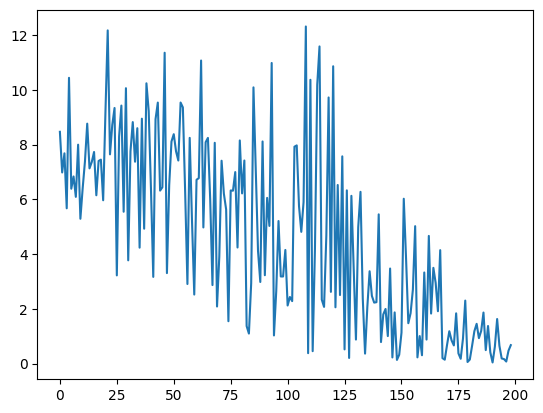

In [199]:
x = np.arange(len(losses))
plt.plot(x, losses)
plt.show()

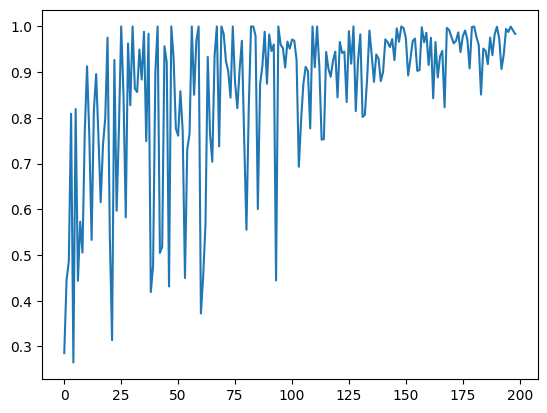

In [200]:
plt.plot(x, accs)
plt.show()

In [201]:
class NCPS:
    def __init__(self, model, data):
        self.model = model
        self.h_dim = model.h_dim
        self.g_dim = model.g_dim
        self.x_dim = model.x_dim

        self.N = data.shape[1]
        data = torch.tensor(data).float()
        data = data.view((self.N, self.x_dim))
        self.hs = model.h(data)
        self.qs = model.q(data)
        self.f = model.f
        self.g = model.g

    def sample(self, S):
        self.model.eval()
        cs = torch.zeros([S, self.N], dtype=torch.int64)
        previous_maxK = 1
        nll = torch.zeros(S)

        with torch.no_grad():
            for n in range(1, self.N):
                Ks, _ = cs.max(dim=1)
                Ks += 1
                maxK = Ks.max().item()
                minK = Ks.min().item()
                inds = {}

                for K in range(minK, maxK + 1):
                    inds[K] = Ks == K

                if n == 1:
                    self.Q = self.qs[2:, :].sum(dim=0).unsqueeze(0)
                    self.Hs = torch.zeros((S, 2, self.h_dim))
                    self.Hs[:, 0, :] = self.hs[0, :]
                else:
                    if maxK > previous_maxK:
                        new_h = torch.zeros((S, 1, self.h_dim))
                        self.Hs = torch.cat((self.Hs, new_h), dim=1)

                    self.Hs[np.arange(S), cs[:, n - 1], :] += self.hs[n - 1, :]

                    if n == self.N - 1:
                        self.Q = torch.zeros((1, self.h_dim))
                    else:
                        self.Q[0, :] -= self.qs[n, :]

                previous_maxK = maxK
                logprobs = torch.zeros((S, maxK + 1))
                rQ = self.Q.repeat(S, 1)

                for k in range(maxK + 1):
                    Hs2 = self.Hs.clone()
                    Hs2[:, k, :] += self.hs[n, :]
                    Hs2 = Hs2.view((S*(maxK + 1), self.h_dim))
                    gs = self.g(Hs2).view((S, (maxK + 1), self.g_dim))

                    for K in range(minK, maxK + 1):
                        if k < K:
                            gs[inds[K], K:, :] = 0
                        elif k == K and K < maxK:
                            gs[inds[K], (K + 1):, :] = 0

                    Gk = gs.sum(dim=1)
                    uu = torch.cat((Gk, rQ), dim=1)
                    logprobs[:, k] = torch.squeeze(self.f(uu))

                for K in range(minK, maxK):
                    logprobs[inds[K], K + 1:] = float('-Inf')

                m, _ = torch.max(logprobs, 1, keepdim=True)
                logprobs = logprobs - m - torch.log(torch.exp(logprobs - m).sum(dim=1, keepdim=True))
                probs = torch.exp(logprobs)
                m = Categorical(probs)
                ss = m.sample()
                cs[:, n] = ss
                nll -= logprobs[np.arange(S), ss]

        cs = cs.numpy()
        nll = nll.numpy()
        sorted_nll = np.sort(list(set(nll)))
        Z = len(sorted_nll)
        probs = np.exp(-sorted_nll)
        css = np.zeros((Z, self.N), dtype=np.int32)

        for i in range(Z):
            snll = sorted_nll[i]
            r = np.nonzero(nll == snll)[0][0]
            css[i, :] = cs[r, :]

        return css, probs

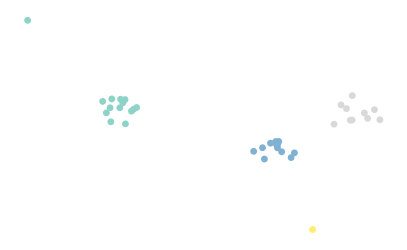

In [209]:
sampler = NCPS(dpmm, data[:1])
css, probs = sampler.sample(10)
show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[1]]), css[0])

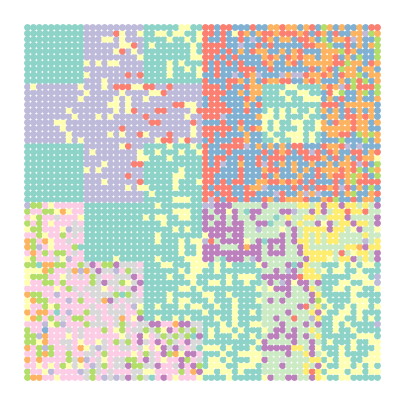

In [223]:
sampler = NCPS(dpmm, data[:, 3:][None])
css, probs = sampler.sample(20)
show_dataset(data, css[0])